https://github.com/pytorch/examples/blob/master/mnist/main.py
https://hacks.deeplearning.jp/pytorch%E3%81%AEdataloader/

### Network Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

n_shot = 1
n_class = 10
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_class)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

    # for MAML local optimize
    def manual_forward(self, x, params):
        x = F.relu(F.max_pool2d(
            F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device)), 2))
        x = F.relu(F.max_pool2d(
            F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device)), 2))
        x = x.view(-1, 320)
        x = F.relu(
            F.linear(x, params['fc1.weight'].to(device), params['fc1.bias'].to(device)))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(
            F.linear(x, params['fc2.weight'].to(device), params['fc2.bias'].to(device)), dim=1)
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    return test_loss, correct / len(test_data_loader.dataset)

### Dataset

In [2]:
class OmniglotDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_indices, transform):

        self.data = []
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_indices]
            else:
                test_indices = list(set(np.arange(20)) - set(train_indices)) # 各文字20枚ずつ入ってる
                chars = chars[test_indices]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)
        return [torch.from_numpy(image), torch.from_numpy(label)]

### DataLoader

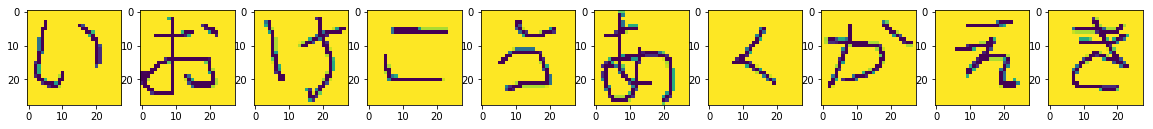

tensor([1, 4, 8, 9, 2, 0, 7, 5, 3, 6])


In [3]:
local_task_train_data_loader = DataLoader(
    OmniglotDataset("../data/omniglot_mini/images_background/Japanese_(hiragana)/", 
                    n_class=n_class,
                    train=True,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

for batch in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(20,2))
    for i, (image, label) in enumerate(zip(batch[0], batch[1])):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(image[0])
    plt.show()
    print(batch[1])

### fit
- task=Japanese-hiragana, 20classes, 1shot

In [4]:
local_task_train_data_loader = DataLoader(
    OmniglotDataset("../data/omniglot_mini/images_background/Japanese_(hiragana)/", 
                    n_class=n_class,
                    train=True,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

local_task_test_data_loader = DataLoader(
    OmniglotDataset("../data/omniglot_mini/images_background/Japanese_(hiragana)/", 
                    n_class=n_class,
                    train=False,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=20).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(1, 1000 + 1)) as _tqdm:
    for epoch in _tqdm:
        train(model, device, local_task_train_data_loader, optimizer, epoch)
        temp_loss, temp_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))

  5%|▍         | 47/1000 [00:02<00:43, 21.88it/s, step=49, loss=2.44, acc=0.0947]


KeyboardInterrupt: 

### Taskset and TaskLoader
- original classes

In [5]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return NotImplementedError

### Taskset

In [6]:
class OmniglotTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_lang = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_lang = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_lang))
        tasks = [os.path.join(path_to_lang, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
        
    def __len__(self):
        return len(self.tasks)
 
    def __getitem__(self, idx):
        train_indices=[0] #TODO chanege indices
        return {"train":
                DataLoader(
                    OmniglotDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### TaskLoader

30
../data/omniglot_mini/images_background/Cyrillic


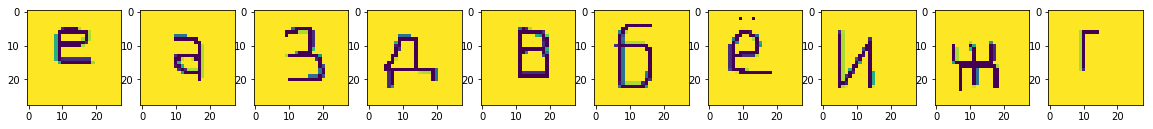

tensor([5, 0, 8, 4, 2, 1, 6, 9, 7, 3])
../data/omniglot_mini/images_background/Ojibwe_(Canadian_Aboriginal_Syllabics)


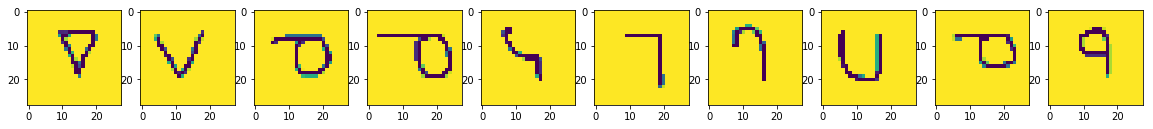

tensor([0, 1, 8, 6, 9, 5, 4, 2, 7, 3])
../data/omniglot_mini/images_background/Greek


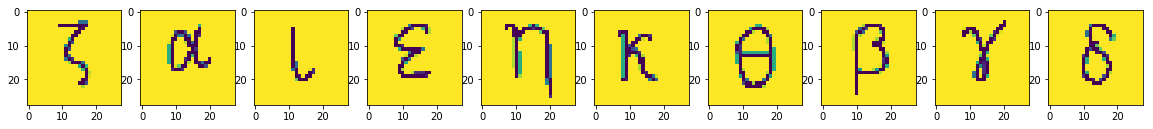

tensor([5, 0, 8, 4, 6, 9, 7, 1, 2, 3])
../data/omniglot_mini/images_background/Burmese_(Myanmar)


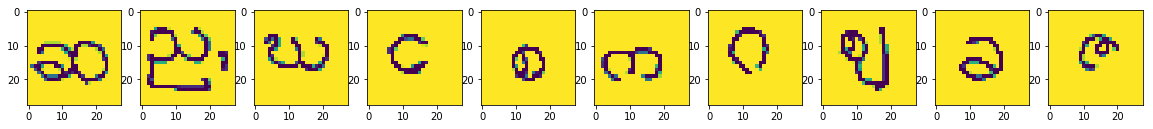

tensor([6, 9, 3, 4, 5, 0, 2, 8, 1, 7])
../data/omniglot_mini/images_background/Balinese


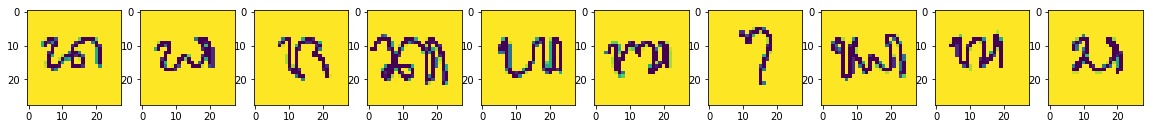

tensor([3, 0, 8, 9, 7, 1, 4, 5, 6, 2])


In [7]:
meta_train_task_loader = TaskLoader(
    OmniglotTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for task_i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    local_task_train_data_loader = meta_train_task["train"]
    for batch in local_task_train_data_loader:
        plt.figure(figsize=(20,2))
        for i, (image, label) in enumerate(zip(batch[0], batch[1])):
            plt.subplot(1, batch_size, i+1)
            plt.imshow(image[0]) # image.shape=[1,28,28]
        plt.show()
        print(batch[1])
    if task_i==4:
        break

---

# MAML

In [8]:
class MetaLearner(object):
    def __init__(self):
        self.lr = 0.01
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    #TODO need return or not
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        loss, acc = [], []
        
        for meta_test_task in meta_test_task_loader:
            
            # copy master model to new branch model
            faster_net = OmniglotNet(n_class).to(self.device)
            self.copy_params(self.master_net, faster_net)
            faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)
            
            # make local task data loader
            local_task_train_data_loader = meta_test_task["train"]
            local_task_test_data_loader = meta_test_task["test"]
            
            # ----------------------------------------------------------------
            # meta test task train
            # ----------------------------------------------------------------
            
            for epoch in range(n_local_update):
                train(faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
            
            # ----------------------------------------------------------------
            # meta test task test
            # ----------------------------------------------------------------
            
            _loss, _acc = test(faster_net, self.device, local_task_test_data_loader)
            loss.append(_loss)
            acc.append(_acc)
            
        print("meta_test_loss: {:.3f}, meta_test_acc: {:.3f}".format(
            np.mean(loss), np.mean(acc)))
    
    def meta_train(self):
        
        meta_train_task_loader = TaskLoader(
            OmniglotTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
        
        meta_grads = []
        
        for meta_train_task in meta_train_task_loader:
            
            # copy master model to new branch model
            faster_net = OmniglotNet(n_class).to(self.device)
            self.copy_params(self.master_net, faster_net)
            
            faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
            master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())
        
            # make local task data loader
            local_task_train_data_loader = meta_train_task["train"]
            local_task_test_data_loader = meta_train_task["test"]
            
            # ----------------------------------------------------------------
            # meta train task train
            # ----------------------------------------------------------------
 
            # train n_local_update times / 1 task
            first_train_for_this_task = True
            
            for epoch in range(n_local_update): 
                
                for data, target in local_task_train_data_loader:
                    
                    data, target = data.to(self.device), target.to(self.device)
                    
                    if first_train_for_this_task:
                        # manual predict
                        output = faster_net.manual_forward(data, master_params)
                        loss = F.nll_loss(output, target)

                        # manual optimize
                        grads = torch.autograd.grad(loss, master_params.values(), create_graph=True)
                        
                        first_train_for_this_task = False
                    
                    else:
                        # manual predict
                        output = faster_net.manual_forward(data, faster_params)
                        loss = F.nll_loss(output, target)

                        # manual optimize
                        grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)
                                                
                    faster_params = OrderedDict(
                        (name, param - self.lr*grad) 
                        for ((name, param), grad) in zip(faster_params.items(), grads)
                    )
                            
            # ----------------------------------------------------------------
            # meta train task test
            # ----------------------------------------------------------------
            
            for data, target in local_task_test_data_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                output = faster_net.manual_forward(data, faster_params)
                loss = F.nll_loss(output, target)

                # manual optimize!!!
                grads = torch.autograd.grad(loss, master_params.values(), create_graph=True)
                
                grads = {name:g for ((name, _), g) in zip(self.master_net.named_parameters(), grads)}
                
                meta_grads.append(grads) # TODO normalize grads by local_task_test_data_size
                                
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct = pred.eq(target.view_as(pred)).sum().item()
            
        # summing up grads
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        dumy_data_loader = DataLoader(
            OmniglotDataset("../data/omniglot_mini/images_background/Japanese_(hiragana)/", 
                            n_class=n_class,
                            train=True,
                            train_indices=[0],
                            transform=transforms.Compose([
                                ToTensor()
                            ])),
            batch_size=batch_size, shuffle=True)
        
        data, target = dumy_data_loader.__iter__().next()
        data, target = data.to(self.device), target.to(self.device)
        
#         output = self.master_net.manual_forward(data, master_params) ##########not manual
        output = self.master_net(data) ##########not manual
        loss = F.nll_loss(output, target)
        
        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))
#         print(hooks)
            
        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        loss.backward()
        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()
        
        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

In [ ]:
meta_learner = MetaLearner()

for i in range(5):
    meta_learner.meta_train()
    meta_learner.meta_test()